# STAGE 1

<details>
<summary><b>Overview</b></summary>

## CIFAR-10 Classification using Transfer Learning

This project demonstrates how to classify CIFAR-10 images using pretrained deep CNN architectures (ResNet50, VGG16, DenseNet121) via transfer learning.  
The main goals are to train accurate classifiers, evaluate their performance, and analyze metrics including accuracy, confusion matrices, and ROC-AUC scores.

---

## Workflow Steps

### 1. Load and Preprocess Data
- Load CIFAR-10 dataset using TensorFlow Keras.
- Flatten labels for easier processing.
- Normalize image pixel values to the [0,1] range.
- Convert labels to one-hot encoding for categorical cross-entropy.

### 2. Data Augmentation
- Apply random rotations, width/height shifts, and horizontal flips using `ImageDataGenerator`.
- Helps improve generalization and prevent overfitting.

### 3. Model Setup (Transfer Learning)
- Use pretrained models: ResNet50, VGG16, DenseNet121 with ImageNet weights.
- Remove the original top layers and add custom classification head:
  - Global Average Pooling
  - Dense layer with 256 units + ReLU
  - Dropout (0.4)
  - Output layer with 10 units (softmax)

### 4. Training Strategy
- **Phase 1:** Freeze base model and train only the custom head for several epochs.
- **Phase 2 (Fine-tuning):** Unfreeze last 30 layers of the base model and continue training at a lower learning rate.

### 5. Evaluation
- Compute standard metrics: Accuracy, Precision, Recall, F1-Score.
- Plot confusion matrices for each model to visualize misclassifications.
- Store results in a DataFrame for easy comparison.

### 6. ROC-AUC Computation
- Binarize test labels for multi-class ROC-AUC computation.
- Compute macro-average ROC-AUC scores for each model to assess probabilistic calibration.

---

</details>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
    )

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

(50000, 32, 32, 3)


Text(0.5, 1.0, 'Label: 6')

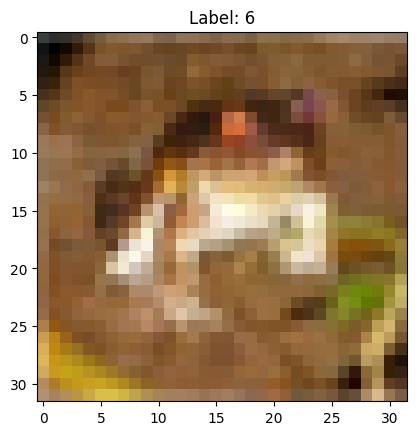

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

num_classes = 10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(x_train.shape)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

plt.imshow(x_train[0]);
plt.title(f"Label: {y_train[0]}")

In [ ]:
# Data augmentation
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def build_model(base_model_fn, name):
    base = base_model_fn(weights='imagenet', include_top=False, input_tensor=Input(shape=(32, 32, 3)))
    base.trainable = False  # Phase 1: freeze

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out, name=name)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model, base

# Training
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 5

callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]

models_to_train = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "DenseNet121": DenseNet121
}

trained_models = {}

for name, base_fn in models_to_train.items():
    print(f"\n Training {name} — Phase 1")
    model, base = build_model(base_fn, name)
    history1 = model.fit(
        datagen.flow(x_train, y_train_cat, batch_size=64),
        epochs=EPOCHS_PHASE1,
        validation_data=(x_test, y_test_cat),
        callbacks=callbacks
    )

    # Finetune (Phase 2)
    print(f"\n Fine tuning {name} — Unfreezing last 30 layers")
    for layer in base.layers[-30:]:
        layer.trainable = True

    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    history2 = model.fit(
        datagen.flow(x_train, y_train_cat, batch_size=64),
        epochs=EPOCHS_PHASE2,
        validation_data=(x_test, y_test_cat),
        callbacks=callbacks
    )

    trained_models[name] = model



 Training ResNet50 — Phase 1
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - accuracy: 0.1360 - loss: 2.4803 - val_accuracy: 0.2506 - val_loss: 2.1242
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.2136 - loss: 2.1467 - val_accuracy: 0.2919 - val_loss: 2.0345
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.2389 - loss: 2.0792 - val_accuracy: 0.3026 - val_loss: 1.9832
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.2541 - loss: 2.0352 - val_accuracy: 0.3132 - val_loss: 1.9374
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.2655 - loss: 2.0070 - val_accuracy: 0.3203 - val_loss: 1.9146
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.2761 - loss: 1.9876 - val_accuracy: 0.3315 - val_loss: 1.8830
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.2852 - loss: 1.9615 - val_accuracy: 0.3324 - val_loss: 1.8720
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.2889 - loss: 1.9515 - val_accurac

In [9]:
import os

save_dir = "/content/saved_models"
os.makedirs(save_dir, exist_ok=True)

for name, model in trained_models.items():
    path = os.path.join(save_dir, f"{name}.keras")
    model.save(path)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


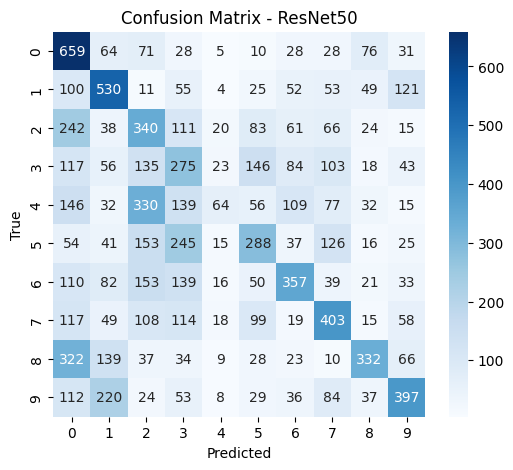

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


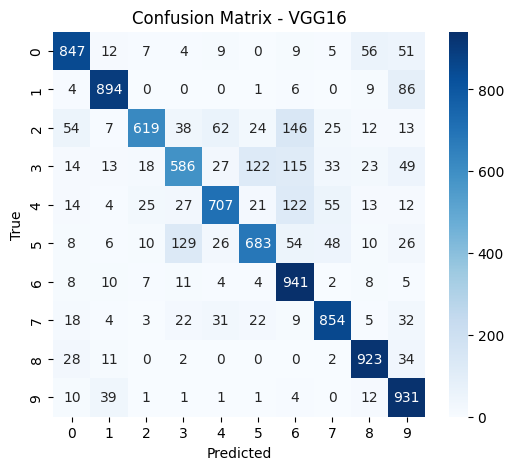

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


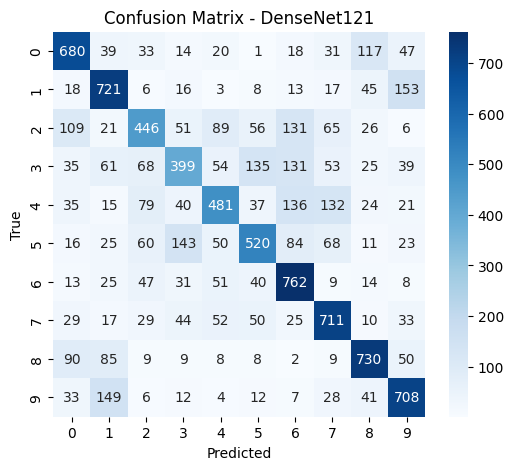

In [11]:
results = []

for name, model in trained_models.items():
    preds = model.predict(x_test)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results.append([name, acc, prec, rec, f1])

    # Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues', fmt='g')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [12]:
import pandas as pd

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
display(df_results)

,Model,Accuracy,Precision,Recall,F1-Score
0,ResNet50,0.3645,0.382193,0.3645,0.352843
1,VGG16,0.7985,0.805836,0.7985,0.794919
2,DenseNet121,0.6158,0.611867,0.6158,0.609357


In [13]:
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(np.argmax(y_test_cat, axis=1), classes=range(10))

for name, model in trained_models.items():
    preds = model.predict(x_test)
    auc = roc_auc_score(y_true_bin, preds, average='macro', multi_class='ovr')
    print(f"{name} ROC-AUC: {auc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
ResNet50 ROC-AUC: 0.8099
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
VGG16 ROC-AUC: 0.9799
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
DenseNet121 ROC-AUC: 0.9288


# STAGE 2

<details>
<summary><b>Overview</b></summary>

## Model Calibration and Robustness Analysis on CIFAR-10

This project evaluates the reliability, calibration, and robustness of pretrained CIFAR-10 classifiers (e.g., ResNet50, VGG16, DenseNet121).  
It focuses on two main aspects:  
1. How well model confidence matches actual accuracy (calibration).  
2. How model performance degrades under common image corruptions (robustness).

---

## Workflow Steps

### 1. Expected Calibration Error (ECE) Computation
- `compute_ece` computes the ECE by:
  - Splitting predicted probabilities into bins.
  - Comparing average confidence and actual accuracy per bin.
  - Aggregating a weighted difference across bins.
- Provides a scalar metric quantifying model calibration.

### 2. Reliability Diagram
- `plot_reliability_diagram` visualizes calibration:
  - X-axis: predicted confidence.
  - Y-axis: empirical accuracy.
  - Bars show accuracy per bin; red dashed line shows mean confidence.
- Helps identify overconfident or underconfident predictions.

### 3. Image Corruption for Robustness Testing
- `apply_corruption` applies controlled corruptions to input images:
  - Gaussian noise
  - Gaussian blur
  - Brightness adjustment
  - JPEG compression
- Severity parameter controls corruption strength (0–1).

### 4. Calibration Evaluation
- For each trained model:
  - Compute ECE on clean test data.
  - Plot reliability diagrams to visually assess calibration.

### 5. Robustness Evaluation
- Evaluate model performance under various corruptions and severities.
- Compute test accuracy for each corruption type and severity level.
- Store results in a structured dictionary for plotting.

### 6. Robustness Visualization
- Plot robustness curves showing accuracy vs. corruption severity for each model.
- Allows comparison of how quickly performance degrades under different perturbations.

---

</details>

In [14]:
from scipy.ndimage import gaussian_filter
from skimage.util import random_noise
from skimage import exposure, img_as_float
from tqdm import tqdm

In [ ]:
models = trained_models

# compute the Expected Calibration Error (ECE) of a model's predictions

def compute_ece(probs, labels, n_bins=15):
    confidences = np.max(probs, axis=1) # Highest predicted probability per sample
    predictions = np.argmax(probs, axis=1) # Predicted class index per sample
    accuracies = (predictions == labels)

    bins = np.linspace(0, 1, n_bins + 1)
    bin_lowers, bin_uppers = bins[:-1], bins[1:]

    ece = 0.0
    # Iterate over each bin and accumulate the weighted absolute difference between confidence and accuracy
    for lower, upper in zip(bin_lowers, bin_uppers):
        mask = (confidences > lower) & (confidences <= upper)
        if np.any(mask):
            acc_bin = np.mean(accuracies[mask])
            conf_bin = np.mean(confidences[mask])
            ece += np.abs(acc_bin - conf_bin) * np.sum(mask) / len(labels)
    return ece

In [ ]:
# plot a reliability diagram for a model's predictions

def plot_reliability_diagram(probs, labels, n_bins=15, title="Reliability Diagram"):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)

    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    accs, confs = [], []

    # Compute accuracy and mean confidence per bin
    for lower, upper in zip(bins[:-1], bins[1:]):
        mask = (confidences > lower) & (confidences <= upper)
        if np.any(mask):
            accs.append(np.mean(accuracies[mask]))
            confs.append(np.mean(confidences[mask]))
        else:
            accs.append(0)
            confs.append(0)

    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.bar(bin_centers, accs, width=1/n_bins, alpha=0.6, edgecolor='black', label='Accuracy per bin')
    plt.plot(bin_centers, confs, 'r--', label='Mean confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
# apply different types of corruptions to a batch of images

def apply_corruption(images, corruption="noise", severity=0.1):
    imgs = img_as_float(images.copy())
    if corruption == "noise":
        # Add Gaussian noise with variance = severity^2
        return np.clip(random_noise(imgs, var=severity**2), 0, 1)
    elif corruption == "blur":
        # Apply Gaussian blur with sigma proportional to severity
        return np.clip(np.stack([gaussian_filter(im, sigma=severity*3) for im in imgs]), 0, 1)
    elif corruption == "brightness":
        # Adjust image brightness using gamma correction
        return np.clip(exposure.adjust_gamma(imgs, gamma=1.0 + severity), 0, 1)
    elif corruption == "compression":
        # Apply JPEG compression by encoding/decoding with reduced quality
        imgs_uint8 = (imgs * 255).astype(np.uint8)
        comp = []
        quality = int(100 - severity*80)
        for im in imgs_uint8:
            jpeg = tf.image.encode_jpeg(im, quality=quality)
            decoded = tf.image.decode_jpeg(jpeg)
            comp.append(decoded.numpy()/255.0)
        return np.array(comp)
    else:
        return imgs

ResNet50 ECE: 0.0363


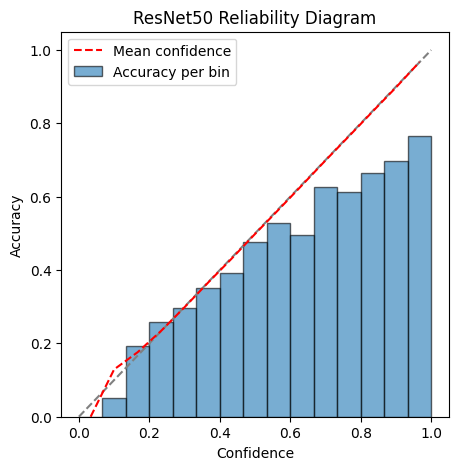

VGG16 ECE: 0.0365


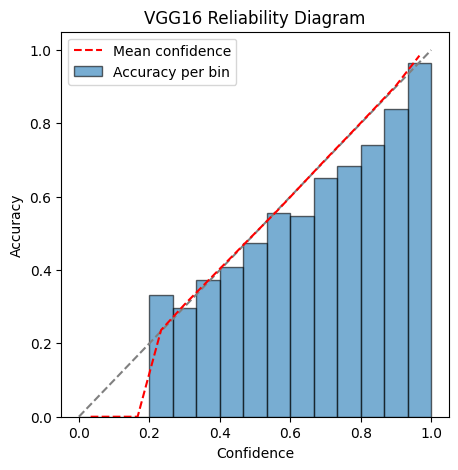

DenseNet121 ECE: 0.0133


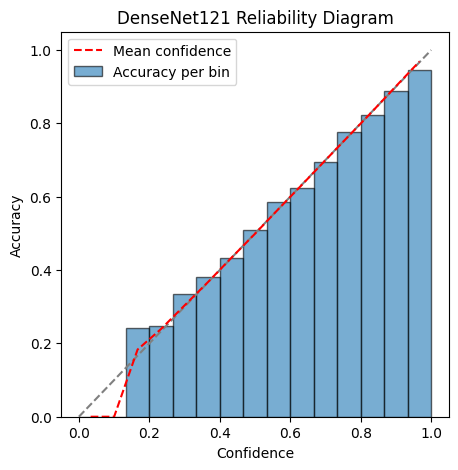

In [19]:
for name, model in models.items():
    preds = model.predict(x_test, verbose=0)
    y_true = y_test

    ece = compute_ece(preds, y_true)
    print(f"{name} ECE: {ece:.4f}")
    plot_reliability_diagram(preds, y_true, title=f"{name} Reliability Diagram")

In [ ]:
corruptions = ["noise", "blur", "brightness", "compression"]
severities = [0.05, 0.1, 0.2, 0.3, 0.4]

robustness_results = {name: {c: [] for c in corruptions} for name in models}

for name, model in models.items():
    print(f"\n {name}")
    for c in corruptions:
        for s in tqdm(severities, desc=f"{c}"):
            x_corr = apply_corruption(x_test, corruption=c, severity=s)
            preds = model.predict(x_corr, verbose=0)
            y_pred = np.argmax(preds, axis=1)
            acc = accuracy_score(y_test, y_pred)
            robustness_results[name][c].append(acc)


 ResNet50


compression: 100%|██████████| 5/5 [00:54<00:00, 10.87s/it]



 VGG16


compression: 100%|██████████| 5/5 [00:55<00:00, 11.10s/it]



 DenseNet121


compression: 100%|██████████| 5/5 [00:59<00:00, 11.86s/it]


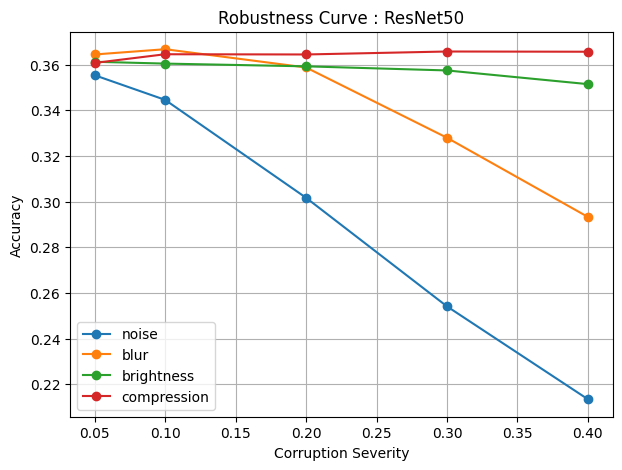

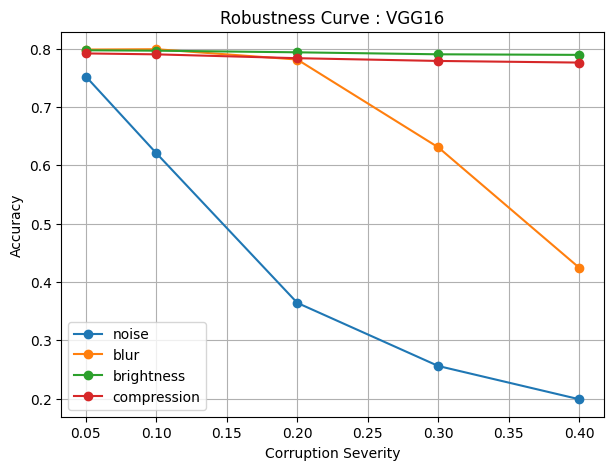

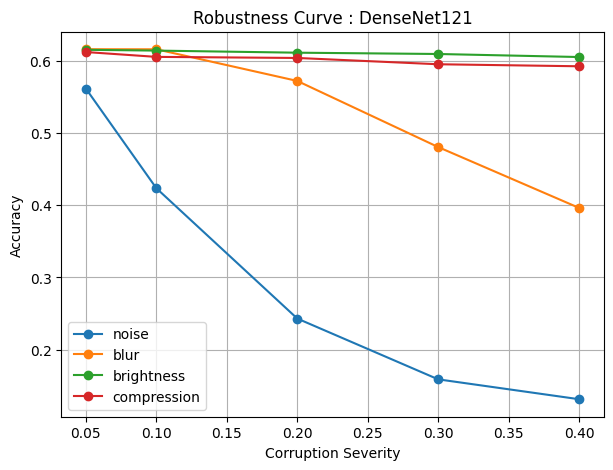

In [21]:
for name in models:
    plt.figure(figsize=(7,5))
    for c in corruptions:
        plt.plot(severities, robustness_results[name][c], marker='o', label=c)
    plt.title(f"Robustness Curve : {name}")
    plt.xlabel("Corruption Severity")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# STAGE 3